In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Foxford/Андрей/preprocessed_titanic.csv')
data.head()

,Survived,Pclass,Age,Fare,Sex,Embarked
0,0,3 класс,22.0,7.2500,male,S
1,1,1 класс,38.0,71.2833,female,C
2,1,3 класс,26.0,7.9250,female,S
3,1,1 класс,35.0,53.1000,female,S
4,0,3 класс,35.0,8.0500,male,S


## Построение корреляции

> Корреля́ция, или корреляцио́нная зави́симость — статистическая взаимосвязь двух или более случайных величин, при этом __изменения значений одной или нескольких из этих величин сопутствуют систематическому изменению значений другой или других величин__.

Корреляция изменяется в диапазоне от -1 до +1. Где -1 - обратная корреляция максимальной силы, а +1 - прямая корреляция максимальной силы

![](https://www.unisender.com/wp-content/uploads/2023/08/slide-4_3-82-1.png)

Если для корреляции нужны только числовые столбцы, то можно настроить внутренний параметр метода pd.DataFrame.corr на построение корреляций только для числовых признаков

```python

data.corr(
  numeric_only = True # использование только числовых столбцов
)

```

In [5]:
data.corr(numeric_only=True)

,Survived,Age,Fare
Survived,1.000000,-0.064910,0.257307
Age,-0.064910,1.000000,0.096688
Fare,0.257307,0.096688,1.000000


Переводим категориальные признаки в числовые

In [6]:
data.head()

,Survived,Pclass,Age,Fare,Sex,Embarked
0,0,3 класс,22.0,7.2500,male,S
1,1,1 класс,38.0,71.2833,female,C
2,1,3 класс,26.0,7.9250,female,S
3,1,1 класс,35.0,53.1000,female,S
4,0,3 класс,35.0,8.0500,male,S


In [7]:
data['Pclass'] = data['Pclass'].apply(lambda x: int(x.split()[0]))
data.head()

,Survived,Pclass,Age,Fare,Sex,Embarked
0,0,3,22.0,7.2500,male,S
1,1,1,38.0,71.2833,female,C
2,1,3,26.0,7.9250,female,S
3,1,1,35.0,53.1000,female,S
4,0,3,35.0,8.0500,male,S


Посмотрим число уникальных групп для признака "Sex" и "Embarked"

In [8]:
print('Количество уникальных значений в признаке "Embarked" равняется {}, а в признаке "Sex" {}'.format(data['Embarked'].nunique(), data['Sex'].nunique()))


Количество уникальных значений в признаке "Embarked" равняется 3, а в признаке "Sex" 2


Перекодируем признак "Sex"

In [9]:
data['Sex'] = data['Sex'].apply(lambda x: 1 if x == 'male' else 0)
# перекодировали мужской пол как 1, женский как 0
data.head()

,Survived,Pclass,Age,Fare,Sex,Embarked
0,0,3,22.0,7.2500,1,S
1,1,1,38.0,71.2833,0,C
2,1,3,26.0,7.9250,0,S
3,1,1,35.0,53.1000,0,S
4,0,3,35.0,8.0500,1,S


Перекодируем признак 'Embarked'

In [10]:
data['Embarked'].value_counts()

# data['Embarked'] = data['Embarked'].replace('S', 1)
# data['Embarked'] = data['Embarked'].replace('C', 2)
# data['Embarked'] = data['Embarked'].replace('Q', 3)

def encoding_embarked(x):
  if x == 'S':
    return 1
  elif x == 'C':
    return 2
  else:
    return 3

data['Embarked'] = data['Embarked'].apply(encoding_embarked)

Документация по [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

<Axes: >

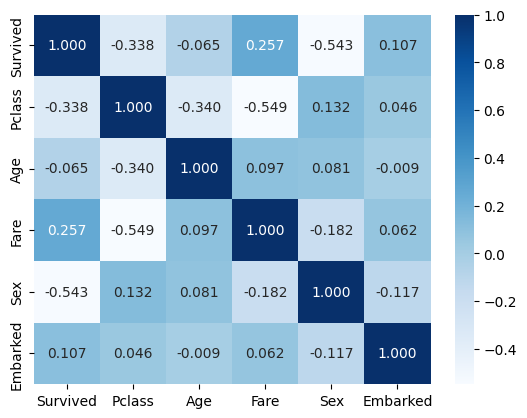

In [11]:
sns.heatmap(data.corr(), # сам скореллированный датасет
            annot=True,  # показатель корреляции внутри каждой ячейки
            cmap='Blues',# изменяем внешний вид корреляции
            fmt=".3f"    # выставляем число знаков после запятой
)

## Методы выявления выбросов

z-отклонение или метод трех сигм

> Выбросами можно считать значения, не попавшие в интервал от µ - 3σ до µ + 3σ, где µ - среднее значение столбца, а σ - стандартное отклонение данных для заданного столбца

In [12]:
# Реализация

x = 'Pclass'
mu = data[x].mean()
sigma = data[x].std()

lower_bound = mu - 3 * sigma
upper_bound = mu + 3 * sigma

cleaned_data = data[(data[x] > lower_bound) & (data[x] < upper_bound)]
cleaned_data.head()

,Survived,Pclass,Age,Fare,Sex,Embarked
0,0,3,22.0,7.2500,1,1
1,1,1,38.0,71.2833,0,2
2,1,3,26.0,7.9250,0,1
3,1,1,35.0,53.1000,0,1
4,0,3,35.0,8.0500,1,1


In [13]:
def outliers_z_score(data, feature):
  mu = data[feature].mean()     # получаем среднее значение столбца
  sigma = data[feature].std()   # получаем среднее отклонение столбца

  lower_bound = mu - 3 * sigma  # находим нижнюю границу выбросов
  upper_bound = mu + 3 * sigma  # находим верхнюю границу выбросов

  outliers = data[(data[x] < lower_bound) | (data[x] > upper_bound)]  # находим выбросы - меньше нижней и больше верхней границ
  cleaned = data[(data[x] >= lower_bound) & (data[x] <= upper_bound)] # находим чистые данные - между двумя границами включительно

  return outliers, cleaned  # возвращаем датасет с выбросами и очищенный

In [15]:
_, cleaned_age = outliers_z_score(data, feature='Age')
_, cleared_data = outliers_z_score(cleaned_age, feature='Fare')

Домашнее задание на 15.07.24

1. Получить очищенные данные по методу трех сигм, для столбцов age, fare
2. На очищенном от выбросов датасете построить новую диаграмму корреляций и тепловую карту
3. __ПО ЖЕЛАНИЮ:__ прочитать про виды кодирования [переменных в данных Python](https://www.dmitrymakarov.ru/data-analysis/encoding-10/#8-ordinal-encoder)

In [ ]:
# Возраст
# < 18 - дети
# 18 < x < 25 - молодые люди
# 25 < x < 45 - взрослые люди
# 45 < x < 65 - предпенсионный возраст
# > 65 - пенсионеры

def encode_age(x):
  if x < 18:
    return 'children'
  elif x >= 18 and x < 25:
    return 'young'
  elif x >= 25 and x < 45:
    return 'adults'
  elif x >= 45 and x < 65:
    return 'old'
  else:
    return 'pensioners'

lambda x: 'children' if x < 18 else 'young' if x >= 18 and x < 25 else 'adults' if x >= 25 and x < 45 else 'old' if x >= 45 and x < 65 else 'pensioners'


'20-12-1980'
lambda x: int(x.split('-')[2])

def become_year(x):
  list_of_date = x.split('-')
  year_string = list_of_date[-1]
  year_int = int(year_string)
  return year_int


In [16]:
cleared_data.to_csv('cleared_titanic.csv', index=False)